In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

import config as cfg

Config.py using existing local data directory /mnt/disks/disk-1/data/no-negative


In [2]:
batch_size = 1024 * 16

In [3]:
train_n_validation = pd.read_csv(os.path.join(cfg.csv_dir, 'train_n_validation_multilabel.csv'))

In [4]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [5]:
np.random.seed(42)

src = (ImageList.from_df(path=cfg.img_path, df=train_n_validation, folder='all')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [6]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))


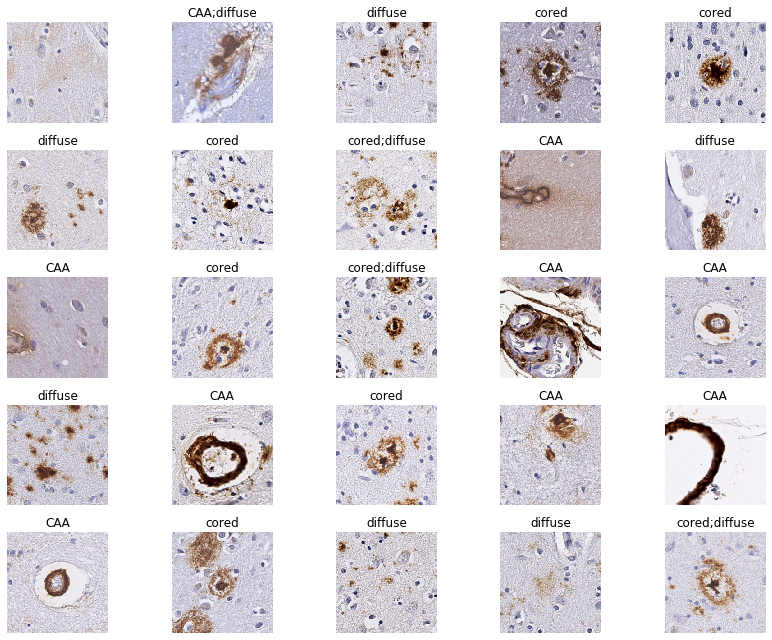

In [7]:
data.show_batch(rows=5, figsize=(12,9))

In [8]:
resnet34 = models.resnet34

In [9]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)

In [10]:
learn = cnn_learner(data, resnet34, metrics=[acc_05, f_score])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 270MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 2.09E-02


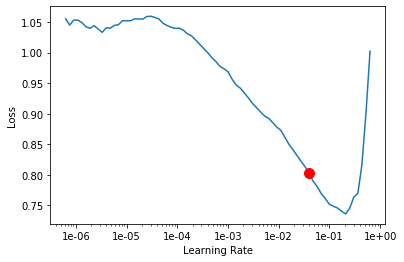

In [11]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(30, slice(1e-5, 1e-01/5))

In [77]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 8.32E-03


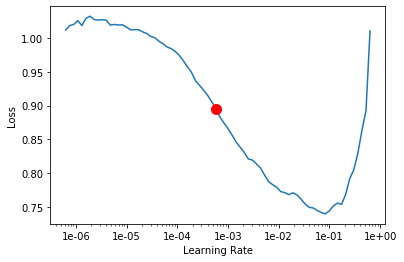

In [78]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [80]:
from fastai.callbacks.tracker import SaveModelCallback, EarlyStoppingCallback

class SaveModelCallbackToDest(SaveModelCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best to specific path."
    def __init__(self,
                 learn:Learner,
                 monitor:str='valid_loss',
                 mode:str='auto',
                 every:str='improvement',
                 name:str='bestmodel',
                 dest:str=None):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name, self.dest = every,name,dest
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
    
    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(os.path.join(self.dest, f'{self.name}_{epoch}'))
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(os.path.join(self.dest, f'{self.name}'))

In [ ]:
# EarlyStoppingCallback(learn,
#                                                                  monitor='valid_loss',
#                                                                  min_delta=0.1,
#                                                                  patience=4)

learn.fit_one_cycle(30, slice(1e-5, 1e-01/5), callbacks=[SaveModelCallbackToDest(learn,
                                                             every='improvement',
                                                             monitor='valid_loss',
                                                             name='rn34-stage1-v1',
                                                             dest=cfg.models_dir),
                                                         
                                                        ])

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.043147,0.048197,0.985163,0.977390,03:46
1,0.042664,0.049285,0.985369,0.977960,03:47
2,0.051965,0.056033,0.983386,0.974737,03:46
3,0.065050,0.068199,0.978290,0.969530,03:47
4,0.078208,0.073857,0.977481,0.966895,03:47
5,0.087613,0.078076,0.974949,0.965257,03:47
6,0.084085,0.081244,0.973896,0.963065,03:46
7,0.077422,0.085845,0.976162,0.965623,03:46
8,0.075137,0.100101,0.978954,0.967822,03:46
9,0.070287,0.068582,0.978916,0.969111,03:46


Better model found at epoch 0 with valid_loss value: 0.04819729924201965.


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save(os.path.join(cfg.models_dir, 'rn34-stage1-v1'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


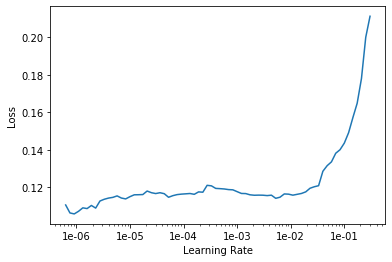

In [42]:
resnet50 = models.resnet50
learn50 = cnn_learner(data, resnet50, metrics=[acc_05, f_score])
learn.lr_find()
learn.recorder.plot()

In [43]:
lr50 = 1e-02

In [44]:
learn50.fit_one_cycle(2, slice(lr50))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.144298,0.130827,0.952186,0.938007,05:34
1,0.128029,0.109618,0.958830,0.945745,05:31


In [45]:
learn50.save(os.path.join(cfg.models_dir, 'stage-1-rn50-v3'))

In [46]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


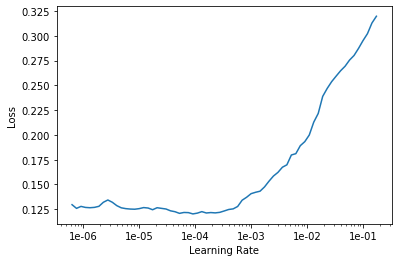

In [47]:
learn50.lr_find()
learn50.recorder.plot()

In [48]:
learn50.fit_one_cycle(5, slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137155,0.139620,0.949333,0.930537,07:53
1,0.125236,0.152772,0.960059,0.944449,07:45
2,0.091744,0.349414,0.970349,0.958063,07:46
3,0.074564,0.073083,0.979411,0.968622,07:46
4,0.063288,0.068320,0.981082,0.971431,07:46


In [49]:
learn50.save(os.path.join(cfg.models_dir, 'stage-2-rn50-v3'))

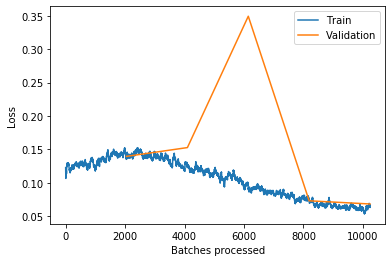

In [50]:
learn50.recorder.plot_losses()

In [51]:
learn50.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


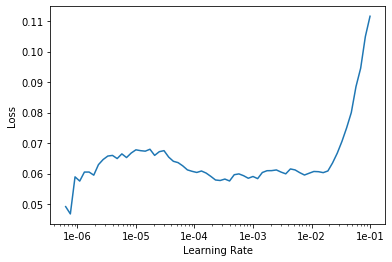

In [52]:
learn50.lr_find()
learn50.recorder.plot()

In [53]:
learn50.fit_one_cycle(2, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.072268,0.072741,0.980167,0.970301,05:27
1,0.071024,0.075032,0.981135,0.972245,05:30


In [54]:
learn50.save(os.path.join(cfg.models_dir, 'stage-3-rn50-v3'))

In [55]:
data_256 = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn50.data = data_256
data_256.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [56]:
learn50.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


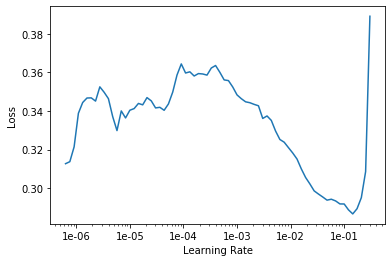

In [57]:
learn50.lr_find()
learn50.recorder.plot()

In [58]:
lr=1e-2
learn50.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124932,0.115341,0.958403,0.945981,20:52
1,0.101864,0.134240,0.966176,0.952304,20:44
2,0.096036,0.125455,0.968877,0.956562,20:31


In [59]:
learn50.save(os.path.join(cfg.models_dir, 'stage-4-256-rn50'))

In [60]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


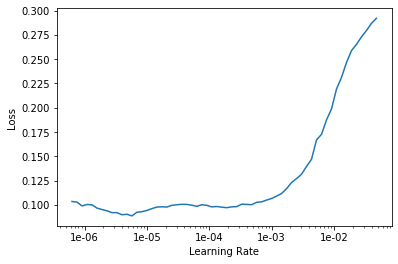

In [61]:
learn50.lr_find()
learn50.recorder.plot()

In [62]:
learn50.fit_one_cycle(2, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097339,0.083388,0.972264,0.959751,27:48
1,0.079276,0.071440,0.978870,0.968229,27:54


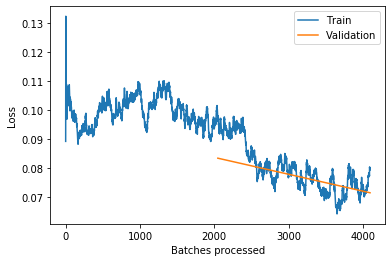

In [63]:
learn50.recorder.plot_losses()

In [64]:
learn50.save(os.path.join(cfg.models_dir, 'stage-5-256-rn50'))

In [65]:
learn50.export(os.path.join(cfg.models_dir, 'stage-5-256-rn50-exported'))